In [4]:
import argparse
import os
import glob
import json
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint

from multimodal.multimodal_data_module import read_vocab, LabeledSEvalDataset, multiModalDataset_collate_fn
from multimodal.multimodal_saycam_data_module import MultiModalSAYCamDataModule, MultiModalSAYCamDataset
# from multimodal.multimodal import MultiModalModel
from multimodal.multimodal_lit import MultiModalLitModel

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_checkpoint_name = "multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8"
# model_checkpoint_name = "multimodal_text_encoder_embedding_lr_0.0001_weight_decay_0.1_fix_temperature_True_batch_size_16"
model_checkpoint = glob.glob(f"/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/{model_checkpoint_name}/*.ckpt")[0]
print(model_checkpoint)
# embedding_checkpoint = "/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8/epoch=199.ckpt"
model = MultiModalLitModel.load_from_checkpoint(model_checkpoint, map_location=device)
model.eval()
print(model.hparams["args"])

/home/wv9/code/WaiKeen/multimodal-baby/checkpoints/multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8/last.ckpt
Namespace(accelerator=None, accumulate_grad_batches=1, amp_backend='native', amp_level='O2', augment_frames=True, auto_lr_find=False, auto_scale_batch_size=False, auto_select_gpus=False, batch_size=8, benchmark=False, bias=True, bidirectional=False, check_val_every_n_epoch=1, checkpoint_callback=True, crange=1, default_root_dir=None, deterministic=False, devices=None, distributed_backend=None, dropout_i=0.0, dropout_o=0.0, embedding_dim=512, embedding_type='flat', exp_name='multimodal_text_encoder_lstm_lr_5e-05_weight_decay_0.1_fix_temperature_True_batch_size_8', fast_dev_run=False, finetune_cnn=False, fix_temperature=True, flush_logs_every_n_steps=100, gpus=1, gradient_clip_algorithm='norm', gradient_clip_val=0.0, ipus=None, lambda_lm=0.0, lambda_mm=1.0, limit_predict_batches=1.0, limit_test_batches=1.0, limit_train_batches=1.0, limit_va

In [5]:
# directories and filenames
DATA_DIR = Path("/misc/vlgscratch4/LakeGroup/shared_data/S_multimodal")
EVAL_FRAMES_DIRNAME = DATA_DIR / "eval"
TRAIN_METADATA_FILENAME = DATA_DIR / "train.json"
VAL_METADATA_FILENAME = DATA_DIR / "val.json"
TEST_METADATA_FILENAME = DATA_DIR / "test.json"
EVAL_DEV_METADATA_FILENAME = DATA_DIR / "eval_dev.json"
EVAL_TEST_METADATA_FILENAME = DATA_DIR / "eval_test.json"
VOCAB_FILENAME = DATA_DIR / "vocab.json"

with open(TRAIN_METADATA_FILENAME) as f:
    train_data = json.load(f)
    train_data = train_data["data"]

with open(VAL_METADATA_FILENAME) as f:
    val_data = json.load(f)
    val_data = val_data["data"]

with open(TEST_METADATA_FILENAME) as f:
    test_data = json.load(f)
    test_data = test_data["data"]

with open(EVAL_DEV_METADATA_FILENAME) as f:
    eval_dev_data = json.load(f)
    eval_dev_data = eval_dev_data["data"]

with open(EVAL_TEST_METADATA_FILENAME) as f:
    eval_test_data = json.load(f)
    eval_test_data = eval_test_data["data"]

# read vocab
def read_vocab(vocab_filename=VOCAB_FILENAME):
    with open(vocab_filename) as f:
        return json.load(f)

# get vocab and reverse
vocab = read_vocab()
vocab_idx2word = dict((v,k) for k,v in vocab.items())

def label_to_category(i):
    label_idx = i.item()
    return vocab_idx2word[label_idx]

# create eval datasets
eval_dev_dataset = LabeledSEvalDataset(eval_dev_data, vocab)
eval_test_dataset = LabeledSEvalDataset(eval_test_data, vocab)

# create dataloaders
eval_dev_dataloader = torch.utils.data.DataLoader(eval_dev_dataset, batch_size=1, shuffle=False)
eval_test_dataloader = torch.utils.data.DataLoader(eval_test_dataset, batch_size=1, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


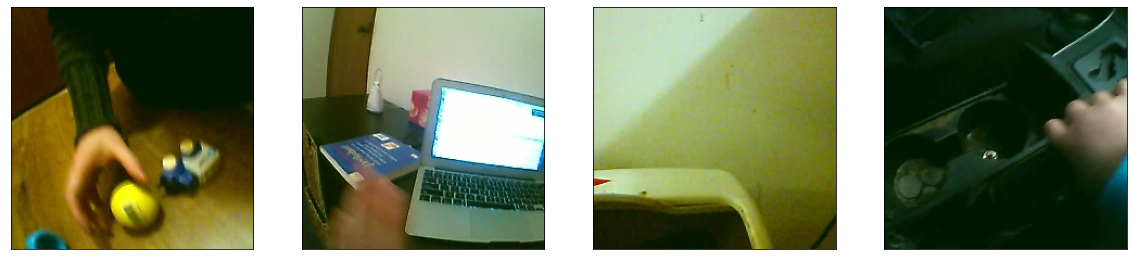

label: ball


In [8]:
# load a single example
# imgs, label, label_len = next(iter(eval_dev_dataloader))
imgs, label, label_len, _ = eval_dev_dataset.__getitem__(29)
# inverse normalization step
from torchvision import transforms
n_inv = transforms.Normalize([-0.485/0.229, -0.546/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

# display images
inv_imgs = imgs.squeeze(0)
inv_imgs = n_inv(inv_imgs)

import matplotlib.pyplot as plt

# extract first image from each batch
plt.figure(figsize=(20, 10))
for i in range(4):
    img = inv_imgs[i].permute((1, 2, 0))

    plt.subplot(1, 4, i+1)
    plt.imshow(img.detach().numpy())
    plt.xticks([])
    plt.yticks([])

plt.show()
    
# get label text
print("label:", label_to_category(label))

/home/wv9/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -0.00037761507
max: 0.0059269946


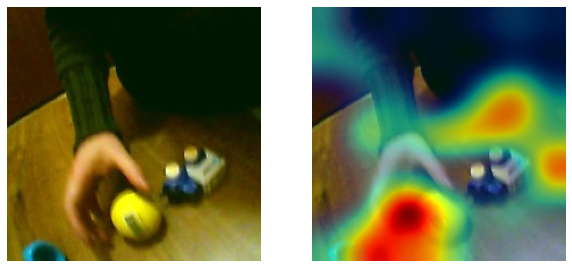

In [11]:
from scipy.ndimage import filters

def normalize(x: np.ndarray) -> np.ndarray:
    # Normalize to [0, 1].
    print("min:", x.min())
    print("max:", x.max())
    x = x - x.min()
    if x.max() > 0:
        x = x / x.max()
    return x

# Modified from: https://github.com/salesforce/ALBEF/blob/main/visualization.ipynb
def getAttMap(img, attn_map, blur=True):
    if blur:
        attn_map = filters.gaussian_filter(attn_map, 0.02*max(img.shape[:2]))
    attn_map = normalize(attn_map)
    cmap = plt.get_cmap('jet')
    attn_map_c = np.delete(cmap(attn_map), 3, 2)
    attn_map = 1*(1-attn_map**0.7).reshape(attn_map.shape + (1,))*img + \
            (attn_map**0.7).reshape(attn_map.shape+(1,)) * attn_map_c
    return attn_map

def viz_attn(img, attn_map, blur=True):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[1].imshow(getAttMap(img, attn_map, blur))
    for ax in axes:
        ax.axis("off")
    plt.show()
    
class Hook:
    """Attaches to a module and records its activations and gradients."""

    def __init__(self, module: nn.Module):
        self.data = None
        self.hook = module.register_forward_hook(self.save_grad)
        
    def save_grad(self, module, input, output):
        self.data = output
        output.requires_grad_(True)
        output.retain_grad()
        
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, exc_traceback):
        self.hook.remove()
        
    @property
    def activation(self) -> torch.Tensor:
        return self.data
    
    @property
    def gradient(self) -> torch.Tensor:
        return self.data.grad

# Reference: https://arxiv.org/abs/1610.02391
def gradCAM(
    model: nn.Module,
    input: torch.Tensor,
    target: torch.Tensor,
    layer: nn.Module
) -> torch.Tensor:
    # Zero out any gradients at the input.
    if input.grad is not None:
        input.grad.data.zero_()
        
    # Disable gradient settings.
    requires_grad = {}
    for name, param in model.named_parameters():
        requires_grad[name] = param.requires_grad
        param.requires_grad_(False)
        
    # Attach a hook to the model at the desired layer.
    assert isinstance(layer, nn.Module)
    with Hook(layer) as hook:        
        # Do a forward and backward pass.
        output = model(input)
        output.backward(target)

        grad = hook.gradient.float()
        act = hook.activation.float()
    
        # Global average pool gradient across spatial dimension
        # to obtain importance weights.
        alpha = grad.mean(dim=(2, 3), keepdim=True)
        # Weighted combination of activation maps over channel
        # dimension.
        gradcam = torch.sum(act * alpha, dim=1, keepdim=True)
        # We only want neurons with positive influence so we
        # clamp any negative ones.
        gradcam = torch.clamp(gradcam, min=0)

    # Resize gradcam to input resolution.
    gradcam = F.interpolate(
        gradcam,
        input.shape[2:],
        mode='bicubic',
        align_corners=False)
    
    # Restore gradient settings.
    for name, param in model.named_parameters():
        param.requires_grad_(requires_grad[name])
        
    return gradcam

# print(model.vision_encoder)
saliency_layer = "layer4"

attn_map = gradCAM(
    model.vision_encoder.model,
    imgs[0].unsqueeze(0).to(device),
    model.model.encode_text(label.unsqueeze(0).to(device), torch.Tensor([1]).to(device)),
    getattr(model.vision_encoder.model, saliency_layer)
)
attn_map = attn_map.squeeze().detach().cpu().numpy()

np_img = inv_imgs[0].permute((1, 2, 0)).cpu().numpy()
blur = True
viz_attn(np_img, attn_map, blur)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'ball')

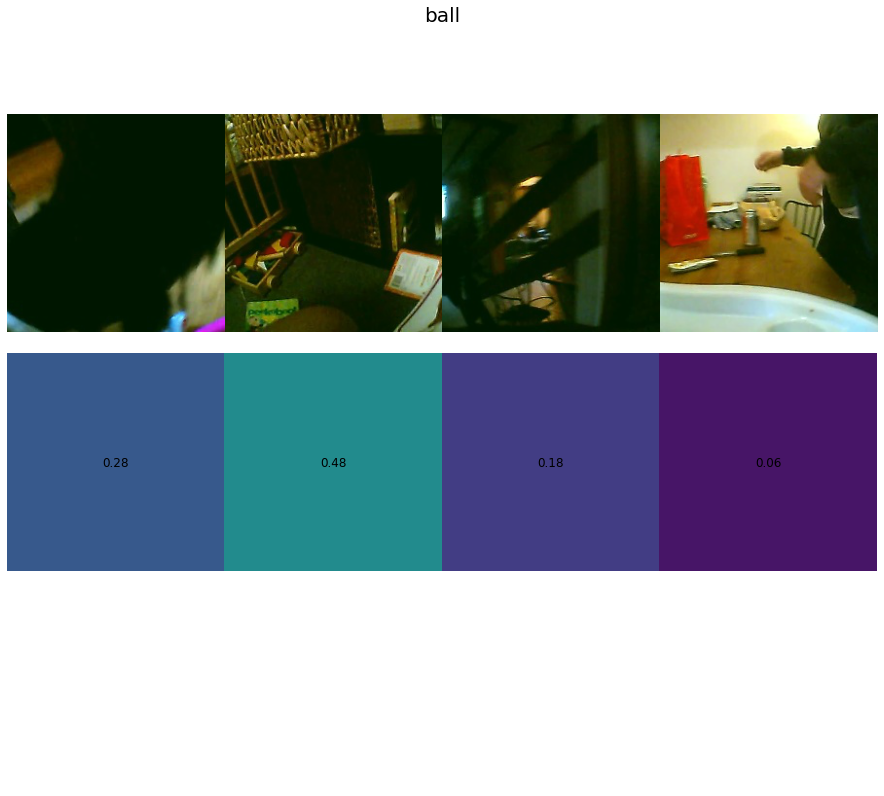

In [13]:
# eval trial
accuracy = 0
# for i in range(100):
imgs, label, label_len, _ = eval_dev_dataset.__getitem__(10)

# move to gpu
imgs = imgs.to(device)
label = label.to(device).unsqueeze(0)
label_len = torch.Tensor([label_len]).to(device)

# reshape imgs along batch dim
imgs = imgs.view(-1, *imgs.shape[-3:])

# calculate accuracy
logits_per_image, logits_per_text = model(imgs, label, label_len)
logits = logits_per_text[0]  # get logits per trial
probs = F.softmax(logits.detach(), dim=0).unsqueeze(0).cpu().numpy()
pred = torch.argmax(logits).item()
correct_label = 0  # correct answer is always the first item
accuracy += int(pred == correct_label)

# inverse normalization step
from torchvision import transforms
n_inv = transforms.Normalize([-0.485/0.229, -0.546/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

# display images
inv_imgs = imgs.squeeze(0)
inv_imgs = n_inv(inv_imgs)

count = 1
plt.figure(figsize=(20, 14))
plt.imshow(probs, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks([0, 1, 2, 3], label_to_category(label), fontsize=18)
plt.xticks([])
for i, image in enumerate(inv_imgs):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(probs.shape[1]):
    for y in range(probs.shape[0]):
        plt.text(x, y, f"{probs[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, 4 - 0.5])
plt.ylim([1 + 0.5, -2])
plt.xticks([])
plt.yticks([])
plt.title(label_to_category(label), size=20)

In [16]:
# validation set visualizations
inv_vocab = dict([(value, key) for key, value in vocab.items()])

def get_captions(labels, label_len):
    captions = []
    for i in range(len(labels)):
        label = labels[i][:label_len[i]][1:-1].cpu().numpy()
        caption = [inv_vocab[j] for j in label]
        caption = ' '.join(caption)
        captions.append(caption)
    return captions

base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
train_dataset = MultiModalSAYCamDataset(train_data, vocab, multiple_frames=True, transform=base_transform)
train_dataloader = iter(torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=multiModalDataset_collate_fn))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cosine similarity between text and image features')

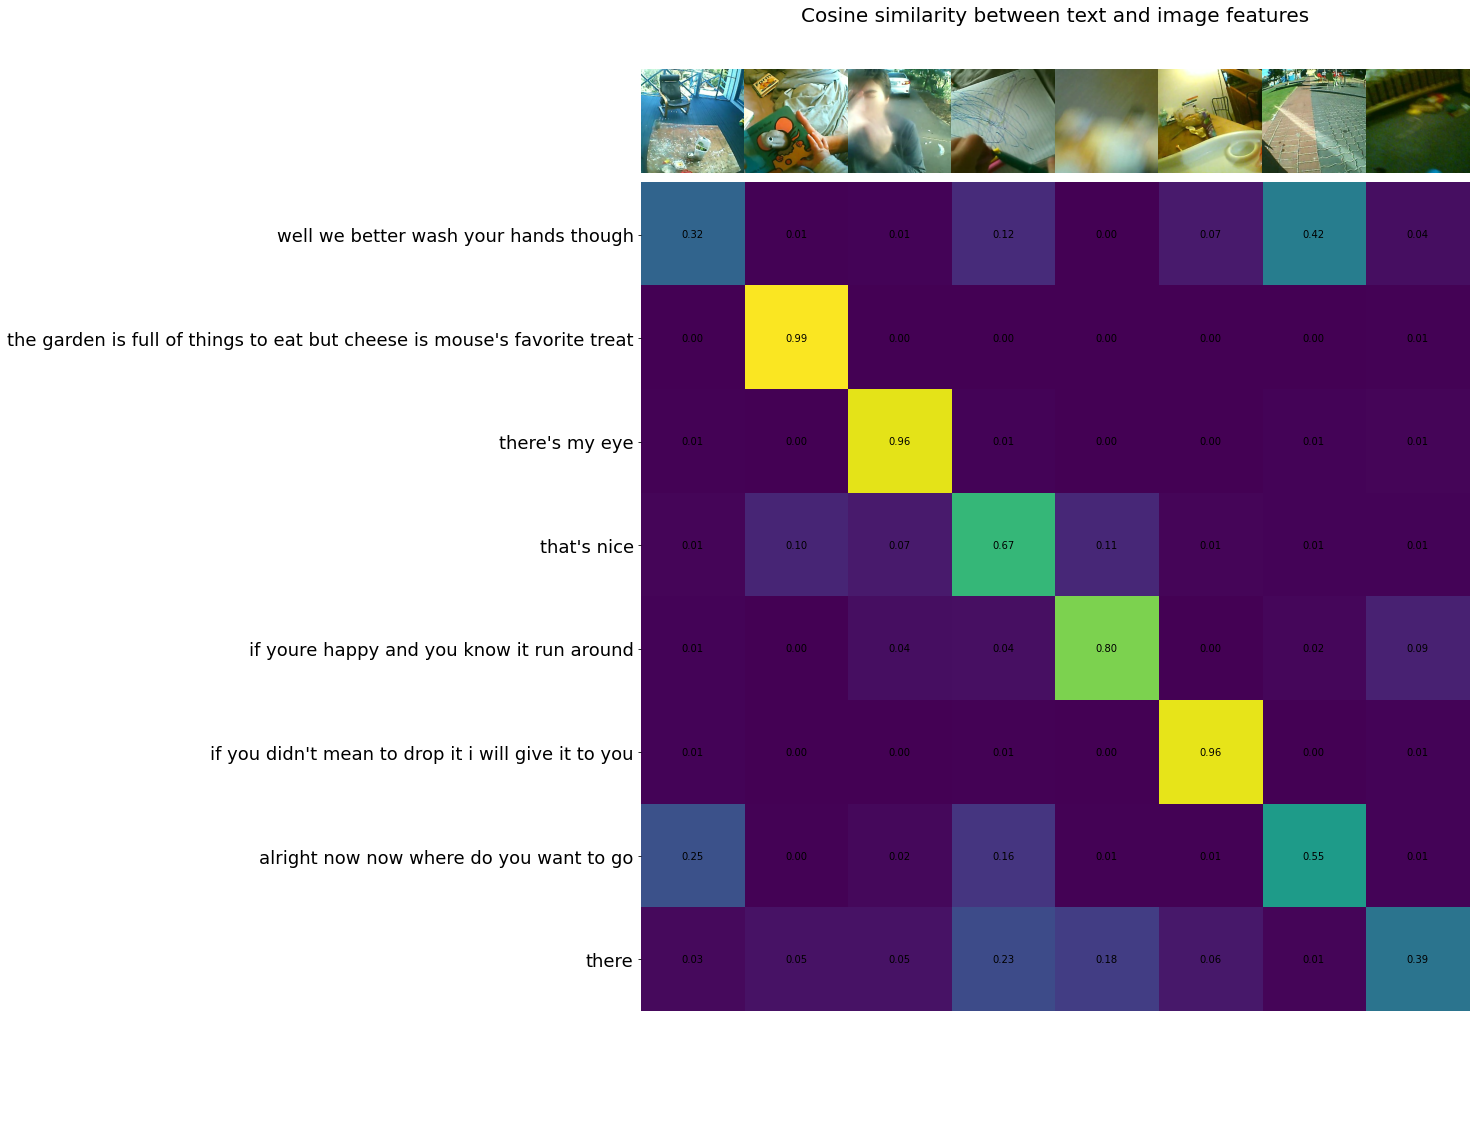

In [18]:
x, y, y_len, _ = train_dataloader.next()
x = x.to(device)
y = y.to(device)
y_len = y_len.to(device)
similarity, _ = model(x, y, y_len)
similarity = F.softmax(similarity, dim=1).detach().cpu().numpy()
captions = get_captions(y, y_len)

count = len(captions)
images = n_inv(x)

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.0, vmax=1.0)
# plt.colorbar()
plt.yticks(range(count), captions, fontsize=18)
plt.xticks([])
for i, image in enumerate(images):
    image = image.permute((1, 2, 0)).detach().cpu().numpy()
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=10)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)